# Classification with Decision Trees

## Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

Set the rng seed.

In [2]:
seed = 17

## Import and view data

In [3]:
df = pd.read_csv("data/train_prepd.csv")
display(df.head())
print('dims: ', df.shape)

Survived  Pclass   Age     Fare  FamSize  Sex_male  Embarked_Q  Embarked_S  \
0       0.0     3.0  22.0   7.2500      1.0       1.0         0.0         1.0   
1       1.0     1.0  38.0  71.2833      1.0       0.0         0.0         0.0   
2       1.0     3.0  26.0   7.9250      0.0       0.0         0.0         1.0   
3       1.0     1.0  35.0  53.1000      1.0       0.0         0.0         1.0   
4       0.0     3.0  35.0   8.0500      0.0       1.0         0.0         1.0   

   Title_Miss  Title_Mr  Title_Mrs  Title_Other  cabin_missing  
0         0.0       1.0        0.0          0.0            1.0  
1         0.0       0.0        1.0          0.0            0.0  
2         1.0       0.0        0.0          0.0            1.0  
3         0.0       0.0        1.0          0.0            0.0  
4         0.0       1.0        0.0          0.0            1.0

dims:  (891, 13)


Decision trees do not support categorical data. Check data types.

In [4]:
df.dtypes

Survived         float64
Pclass           float64
Age              float64
Fare             float64
FamSize          float64
Sex_male         float64
Embarked_Q       float64
Embarked_S       float64
Title_Miss       float64
Title_Mr         float64
Title_Mrs        float64
Title_Other      float64
cabin_missing    float64
dtype: object

Split into dependent and independent variables.

In [5]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

## Build a preliminary classification tree

Split into train and test set. Because data are somewhat imbalanced (38% survived), we'll also use stratification.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = seed)

Build a basic decision tree model and predict the dependent variable for the test set.

Accuracy: 86.03 %


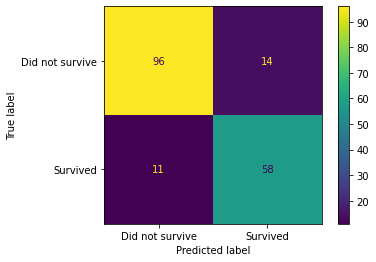

In [7]:
# Build the model shell and fit on the training set.
from sklearn.tree import DecisionTreeClassifier
clf_prel = DecisionTreeClassifier(criterion = 'gini', random_state = seed)
clf_prel.fit(X_train, y_train)

# Predict on the test set. 
y_pred = clf_prel.predict(X_test)

# Calculate accuracy and confusion matrix.
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))

plot_confusion_matrix(clf_prel, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

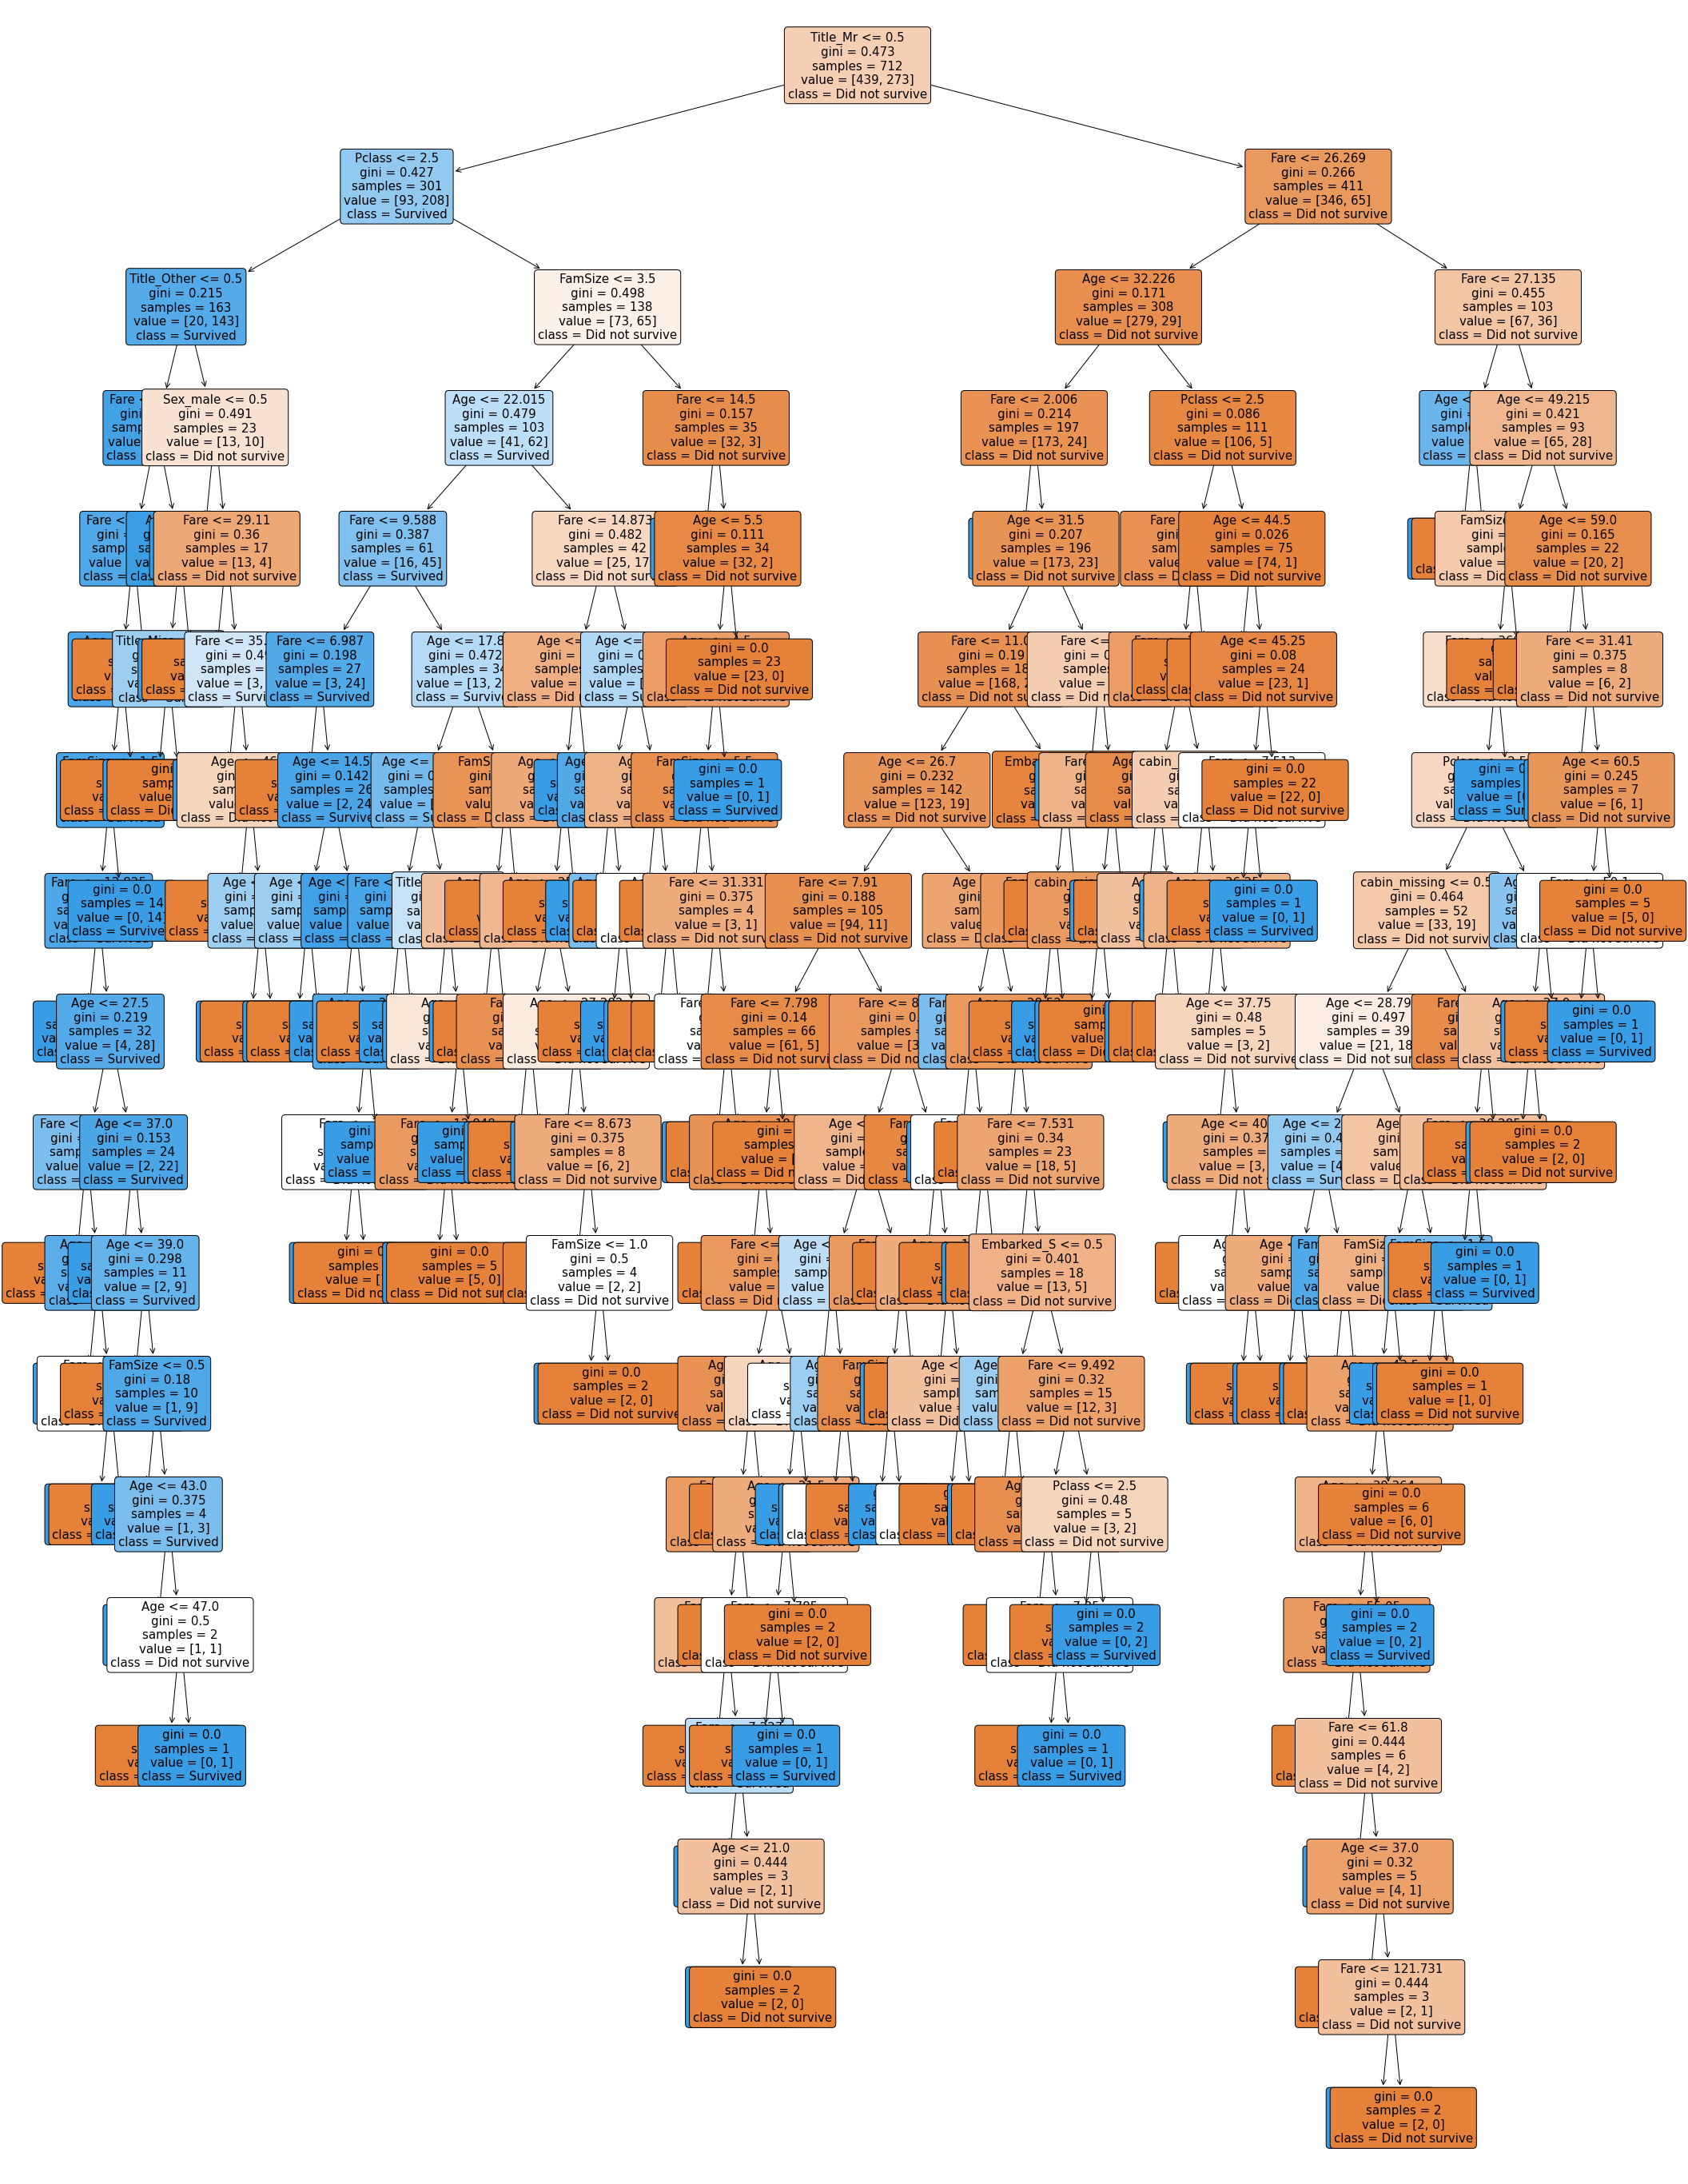

In [8]:
# Draw the decision tree.
plt.figure(figsize=(35,50))
prel_tree = tree.plot_tree(clf_prel, 
                   feature_names=pd.DataFrame(X).columns, 
                   class_names=["Did not survive", "Survived"],
                   filled=True,
                   rounded=True,
                  fontsize=15)


This is a huge tree, definitely overfitting the training data. Examine the fit on the training set.

Accuracy: 99.58 %


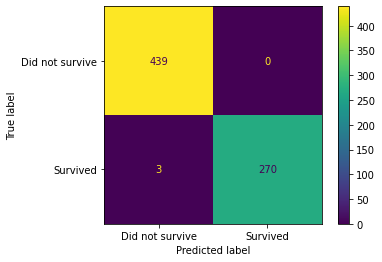

In [9]:
# Predict the dependent variable on the training set.
y_pred_tr = clf_prel.predict(X_train)

# Calculate accuracy and confusion matrix.
acc = accuracy_score(y_train, y_pred_tr)
cm = confusion_matrix(y_train, y_pred_tr)
print('Accuracy: {:.2f} %'.format(acc * 100))

# Draw the confusion matrix
plot_confusion_matrix(clf_prel, 
                     X_train,
                     y_train, display_labels=['Did not survive', 'Survived'])

Get a more robust estimate for the accuracy of the preliminary tree with 10-fold CV (repeated and stratified).

In [10]:
# Create the cv tactic.
cv_rep_str = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# Get CV accuracy and st dev.
scores = cross_val_score(clf_prel, X, y, scoring='accuracy', n_jobs=-1, cv=cv_rep_str)

print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))




scores:  [0.83333333 0.78651685 0.76404494 0.74157303 0.78651685 0.7752809
 0.83146067 0.83146067 0.83146067 0.84269663 0.75555556 0.83146067
 0.75280899 0.88764045 0.86516854 0.85393258 0.79775281 0.87640449
 0.84269663 0.79775281 0.81111111 0.80898876 0.80898876 0.76404494
 0.86516854 0.78651685 0.85393258 0.78651685 0.79775281 0.78651685
 0.75555556 0.82022472 0.83146067 0.76404494 0.75280899 0.80898876
 0.79775281 0.80898876 0.87640449 0.82022472 0.83333333 0.82022472
 0.78651685 0.7752809  0.75280899 0.79775281 0.82022472 0.82022472
 0.79775281 0.7752809 ]
Accuracy: 80.74 %
St.dev: 0.0361


## Hyperparameter tuning / Pruning the tree

The preliminary model is overfit on the training data. I'm going to attempt to find a smaller tree, to increase bias but lower variance. We will try Cost Complexity Pruning.

First, with a train test split.

In [11]:
# get alpha values from the full tree
clf = DecisionTreeClassifier(criterion = 'gini', random_state = seed)
clf.fit(X_train, y_train)

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
# omit the maximum value for alpha, as this is the trivial tree with only a root note.
ccp_alphas = ccp_alphas[:-1]

In [12]:
# fit a tree on each value of alpha and store all of them in a list
dts = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini', random_state=seed, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    dts.append(clf)  

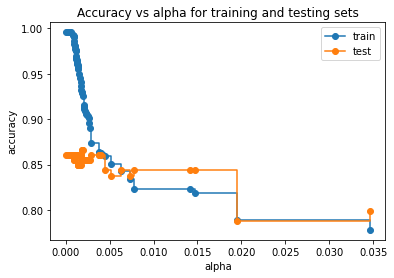

In [13]:
# get train and test scores for each tree
train_scores = [clf.score(X_train, y_train) for clf in dts]
test_scores = [clf.score(X_test, y_test) for clf in dts]


# plot accuracy vs alpha
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [14]:
# return the alpha that yields the highest accuracy for the test set
d = {'alpha': ccp_alphas, 'train': train_scores, 'test': test_scores}
df = pd.DataFrame(data=d)

print('best tree: ')
df.loc[df['test'].idxmax()]

best tree: 


alpha    0.001824
train    0.929775
test     0.865922
Name: 31, dtype: float64

Then with cross validation, because different train test splits will result in different model accuracy. 

In [15]:
dts = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini', random_state=seed, ccp_alpha=alpha)
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    dts.append([alpha, np.mean(scores), np.std(scores)])

In [16]:
alpha_results = pd.DataFrame(dts, columns=['alpha', 'mean', 'std'])
alpha_results.head(50)

alpha      mean       std
0   0.000000  0.766647  0.052578
1   0.000281  0.766647  0.052578
2   0.000351  0.766647  0.052578
3   0.000575  0.766647  0.052578
4   0.000843  0.765239  0.054023
5   0.000843  0.765239  0.054023
6   0.000896  0.765239  0.054023
7   0.000924  0.765239  0.054023
8   0.000988  0.769464  0.055133
9   0.001003  0.769464  0.055133
10  0.001053  0.770872  0.053607
11  0.001053  0.770872  0.053607
12  0.001105  0.772281  0.053130
13  0.001124  0.772281  0.053130
14  0.001204  0.777876  0.058175
15  0.001208  0.777876  0.058175
16  0.001217  0.779284  0.056871
17  0.001229  0.779284  0.056871
18  0.001248  0.780692  0.061600
19  0.001249  0.780692  0.061600
20  0.001264  0.780692  0.061600
21  0.001296  0.783509  0.060607
22  0.001350  0.779343  0.055728
23  0.001374  0.777934  0.057750
24  0.001380  0.777934  0.057750
25  0.001387  0.776526  0.056949
26  0.001565  0.789182  0.060786
27  0.001605  0.789182  0.060786
28  0.001726  0.794816  0.059491
29  0.001756  0.794816  0.059491
30  0.001780  0.794816  0.059491
31  0.001824  0.796225  0.057115
32  0.001873  0.801858  0.052433
33  0.002006  0.810270  0.054598
34  0.002053  0.810290  0.055273
35  0.002107  0.810290  0.055273
36  0.002107  0.810290  0.055273
37  0.002140  0.811698  0.056311
38  0.002154  0.811698  0.056311
39  0.002305  0.813087  0.052254
40  0.002341  0.810270  0.051972
41  0.002417  0.813087  0.044460
42  0.002497  0.814495  0.041084
43  0.002608  0.814515  0.038035
44  0.002672  0.815923  0.032780
45  0.002717  0.818740  0.029558
46  0.002833  0.818740  0.030222
47  0.003773  0.814515  0.033009
48  0.003777  0.814515  0.033009
49  0.003980  0.811698  0.035589

<AxesSubplot:xlabel='alpha'>

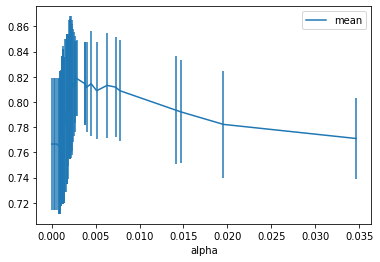

In [17]:
# plot mean accuracy and std. error for different values of alpha
alpha_results.plot(x='alpha', y='mean', yerr='std')

In [18]:
# return the alpha that yields the highest accuracy for the test set
print(alpha_results.loc[alpha_results['mean'].idxmax()])
alpha_best = alpha_results.loc[alpha_results['mean'].idxmax()][0]

alpha    0.002717
mean     0.818740
std      0.029558
Name: 45, dtype: float64


## Build the final model

Accuracy: 85.47 %


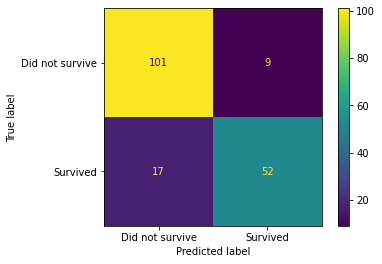

In [19]:
# Create model shell and fit on the training data.
clf = DecisionTreeClassifier(criterion = 'gini', ccp_alpha=alpha_best, random_state = seed)
clf.fit(X_train, y_train)

# Predict on the test data.
y_pred = clf.predict(X_test)

# Get accuracy and confusion matrix.
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))

# Plot the confusion matrix.
plot_confusion_matrix(clf, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

The tree seems to be doing a great job of correctly classifying those that did not survive (Sensitivity: 92%), but does not so well at correctly classifying those that survived (Specificity: 75%).

Plot the pruned tree.

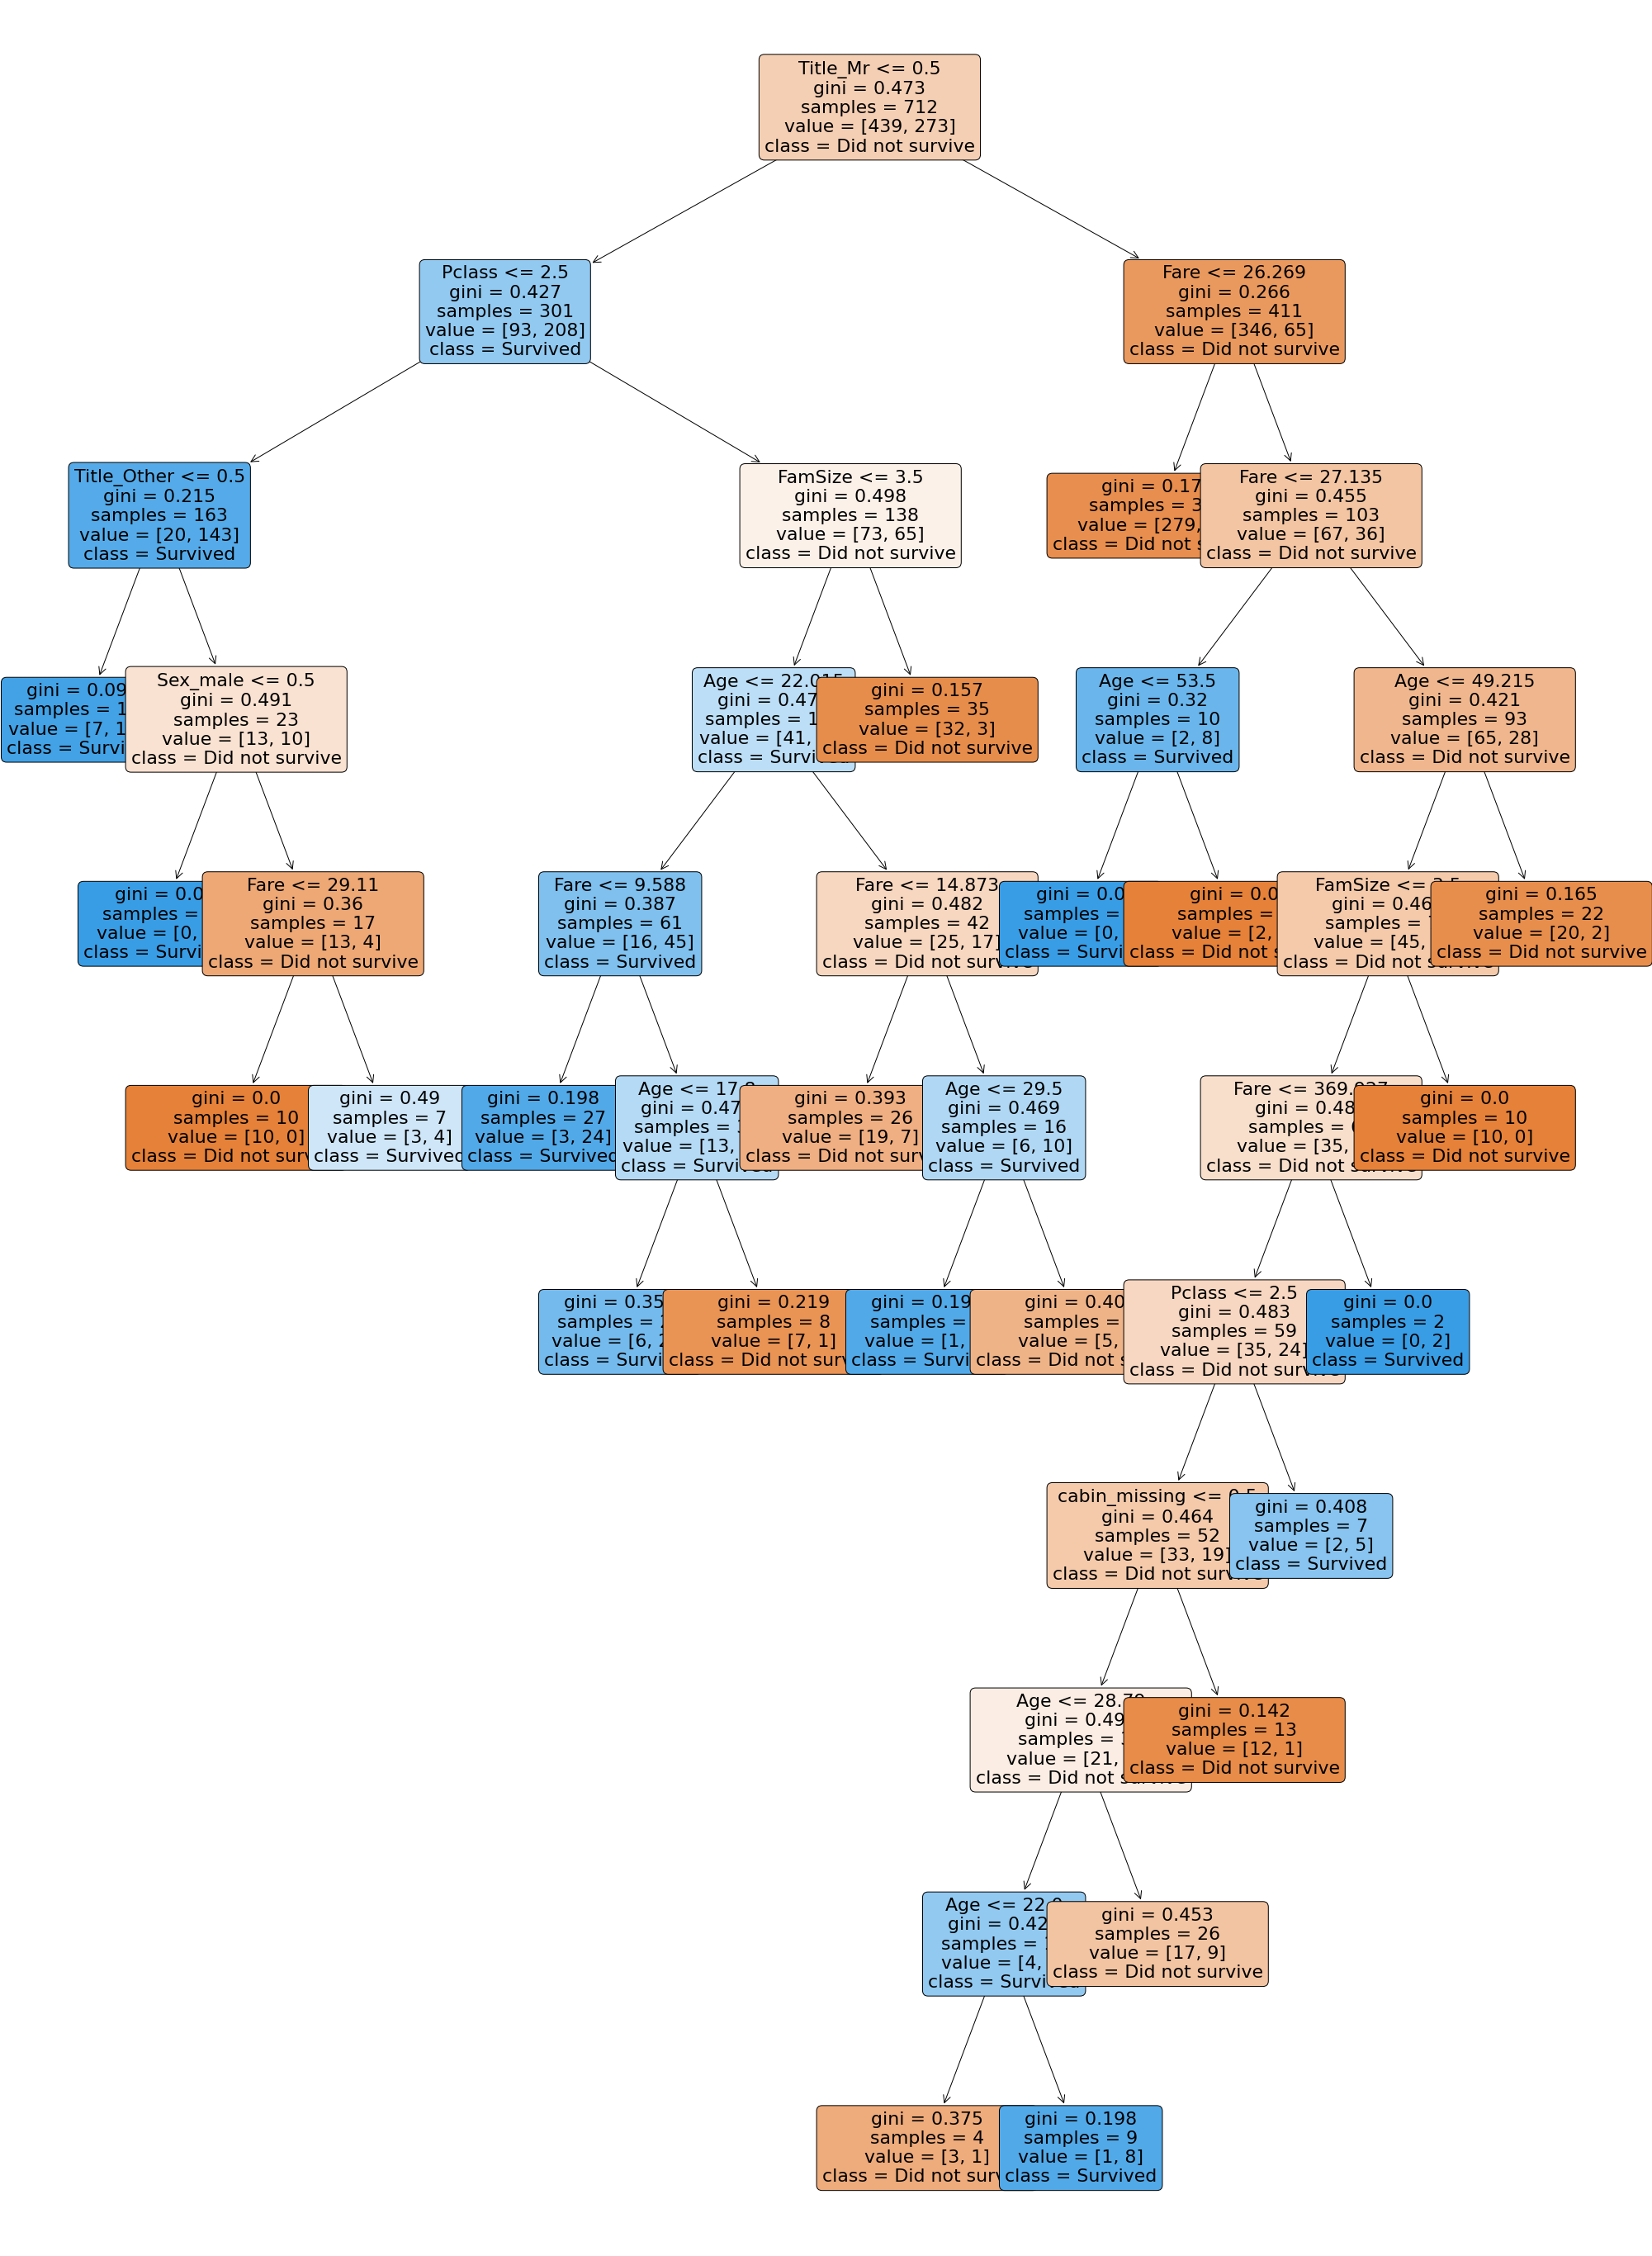

In [20]:
plt.figure(figsize=(35,50))
prel_tree = tree.plot_tree(clf, 
                   feature_names=pd.DataFrame(X).columns, 
                   class_names=["Did not survive", "Survived"],
                   filled=True,
                   rounded=True,
                  fontsize=22)

Re-assess overfitting by predicting the dependent variable on the training set.

Accuracy: 89.04 %


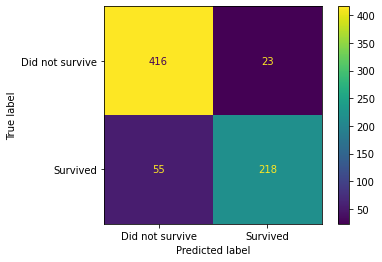

In [21]:
# Predict on the training data
y_pred_tr = clf.predict(X_train)

# Get accuracy and confusion matrix.
acc = accuracy_score(y_train, y_pred_tr)
cm = confusion_matrix(y_train, y_pred_tr)
print('Accuracy: {:.2f} %'.format(acc * 100))

# Plot the confusion matrix.
plot_confusion_matrix(clf, 
                     X_train,
                     y_train, display_labels=['Did not survive', 'Survived'])

Overfitting is significantly reduced.

Get a more robust estimate for the model accuracy, again using repeated and stratified 10-fold CV.

In [22]:
# Create the cv tactic.
cv_rep_str = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# Get CV accuracy and st dev.
scores = cross_val_score(clf, X, y, scoring='accuracy', n_jobs=-1, cv=cv_rep_str)

print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))


scores:  [0.83333333 0.8988764  0.75280899 0.7752809  0.80898876 0.76404494
 0.88764045 0.87640449 0.82022472 0.83146067 0.8        0.83146067
 0.83146067 0.86516854 0.83146067 0.79775281 0.82022472 0.83146067
 0.87640449 0.79775281 0.83333333 0.82022472 0.84269663 0.76404494
 0.84269663 0.7752809  0.8988764  0.79775281 0.82022472 0.7752809
 0.82222222 0.80898876 0.83146067 0.75280899 0.82022472 0.85393258
 0.83146067 0.83146067 0.82022472 0.86516854 0.81111111 0.80898876
 0.80898876 0.79775281 0.7752809  0.85393258 0.87640449 0.84269663
 0.82022472 0.7752809 ]
Accuracy: 82.22 %
St.dev: 0.0357


The final pruned tree performs about 2% better than the preliminary one (82.22% vs 80.74%)